In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils
import math
import matplotlib.patches as patches
import time

import scipy

In [2]:
import importlib  

module = importlib.import_module('0) APIs')
detect_and_refine_boundingBox = module.detect_and_refine_boundingBox

In [3]:
from os import listdir
from os.path import isfile, join
images_paths = [f for f in listdir('../images') if isfile(join('../images', f))]

../images/C128_4.4LOW.BMP


Text(0.5, 1.0, 'Original image')

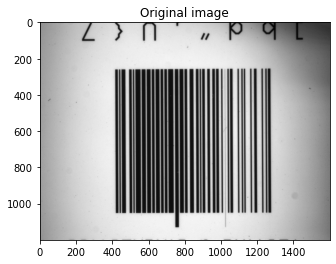

In [5]:
%matplotlib inline
image_path = f'../images/{images_paths[0]}'
print(image_path)
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)   

plt.figure()
plt.imshow(gray, 'gray')
plt.title('Original image')  

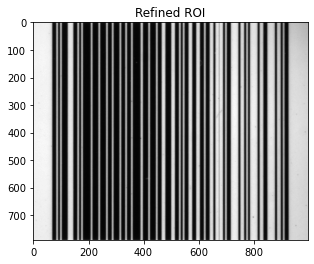

In [6]:
%matplotlib inline
roi_image, bb_points_sorted_rot, bb_width, bb_height = detect_and_refine_boundingBox(image, 
                            use_same_threshold=False, compute_barcode_structure_algorithm=1, verbose_timing=False,
                            outlier_detection_level=0.02, visualization_dict={'visualize_refined_roi':True})

## COMPUTING THE SCAN LINES

In [7]:
bb_height

790

In [8]:
scanlines_indices = np.linspace(start=0, stop=bb_height, num=12, dtype=int)[1:-1]
scanlines_indices

array([ 71, 143, 215, 287, 359, 430, 502, 574, 646, 718])

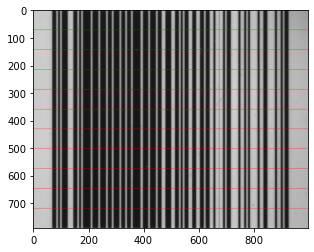

In [9]:
%matplotlib inline
roi_image_tmp = roi_image.copy()
roi_image_tmp = cv2.cvtColor(roi_image_tmp, cv2.COLOR_GRAY2RGB)
roi_image_tmp[scanlines_indices,:,:] = np.array([255,0,0])
plt.figure()
plt.imshow(roi_image_tmp, 'gray') 

## NORMALIZING THE IMAGE

In [10]:
roi_image_norm = 100*(roi_image/255)

In [11]:
roi_image_norm

array([[78.43137255, 77.64705882, 77.25490196, ..., 61.17647059,
        60.        , 58.43137255],
       [76.07843137, 78.43137255, 78.43137255, ..., 60.39215686,
        60.39215686, 59.21568627],
       [77.25490196, 78.82352941, 76.8627451 , ..., 60.78431373,
        59.60784314, 60.        ],
       ...,
       [76.47058824, 76.8627451 , 76.47058824, ..., 68.23529412,
        69.01960784, 69.01960784],
       [76.47058824, 76.8627451 , 76.8627451 , ..., 69.01960784,
        69.41176471, 69.41176471],
       [76.8627451 , 77.64705882, 77.64705882, ..., 69.01960784,
        69.41176471, 69.41176471]])

In [662]:
#roi_image_norm

In [663]:
#roi_image_norm

In [664]:
#roi_image_norm = np.rint(100*(roi_image/255))

In [665]:
#roi_image_norm

## CONSIDERING ONE SCANLINE
We focus on one scanline, and we compute the parameters.

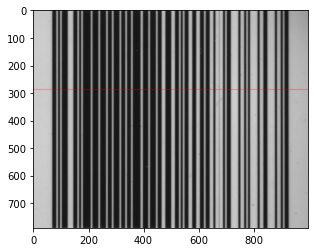

In [12]:
%matplotlib inline
scanline_index = scanlines_indices[3]#math.ceil(bb_height/2)

roi_image_tmp = roi_image.copy()
roi_image_tmp = cv2.cvtColor(roi_image_tmp, cv2.COLOR_GRAY2RGB)
roi_image_tmp[scanline_index,:,:] = np.array([255,0,0])
plt.figure()
plt.imshow(roi_image_tmp, 'gray') 

In [13]:
scanline = roi_image_norm[scanline_index, :]

Text(0.5, 1.0, 'Scan reflectance profile')

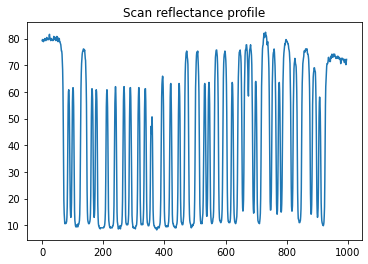

In [14]:
%matplotlib inline
plt.plot(scanline)
plt.title('Scan reflectance profile')

## R_min, R_max, SC, GB

In [15]:
#100*(roi_image[scanline_index,:].max()-roi_image[scanline_index,:].min())/255

In [17]:
#math.floor(scanline.max())-math.floor(scanline.min())

In [18]:
R_min = scanline.min()
R_max = scanline.max()

In [19]:
R_min, R_max

(8.235294117647058, 82.35294117647058)

In [20]:
SC = R_max - R_min
SC

74.11764705882352

In [21]:
GB = R_min + SC/2
GB

45.29411764705882

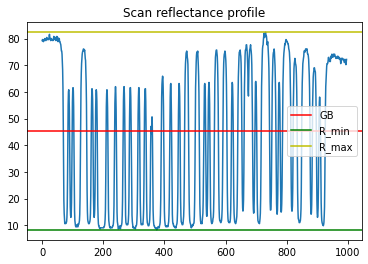

In [22]:
%matplotlib inline
plt.plot(scanline)
plt.axhline(GB, c='r', label='GB')
plt.axhline(R_min, c='g', label='R_min')
plt.axhline(R_max, c='y', label='R_max')
plt.title('Scan reflectance profile')
plt.legend()

The wrong black line within a space can be noticed.

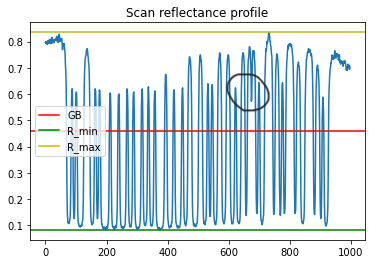

## Edges
Detection of the edges, namely the crossing of a space/bar (passage from a bar to a space or the opposite). The bar/spaces are detected with the $GB$ threshold.

In [25]:
mask = (scanline<GB).astype(int)  # Mask saying which scanline pixel belongs to a bar
print(mask)
print()
mask_1 = np.append([0],mask[:-1])  # Same mask of before, but traslated of one position to the right
print(mask_1) 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [26]:
# Mask saying which scanline pixel is an edge
edges_mask = np.abs(mask - mask_1).astype(bool)
edges_mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
        True, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False,

In [27]:
np.indices((mask.shape[0],))

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [28]:
# Scanline indices of the edge pixels
edges_indices = np.indices(mask.shape)[0][edges_mask]
edges_indices

array([ 70,  85,  90,  99, 104, 126, 146, 161, 167, 175, 181, 210, 215,
       237, 243, 265, 271, 286, 292, 314, 320, 335, 341, 356, 358, 359,
       361, 390, 398, 418, 424, 446, 452, 467, 480, 501, 515, 529, 535,
       543, 549, 564, 577, 592, 605, 620, 626, 641, 654, 661, 689, 696,
       703, 717, 745, 752, 765, 773, 779, 787, 814, 822, 835, 850, 877,
       885, 898, 906, 911, 927])

In [29]:
# Number of elements in the scanline. An element is either a space or a bar
n_elements = len(edges_indices)+1

<IPython.core.display.Javascript object>


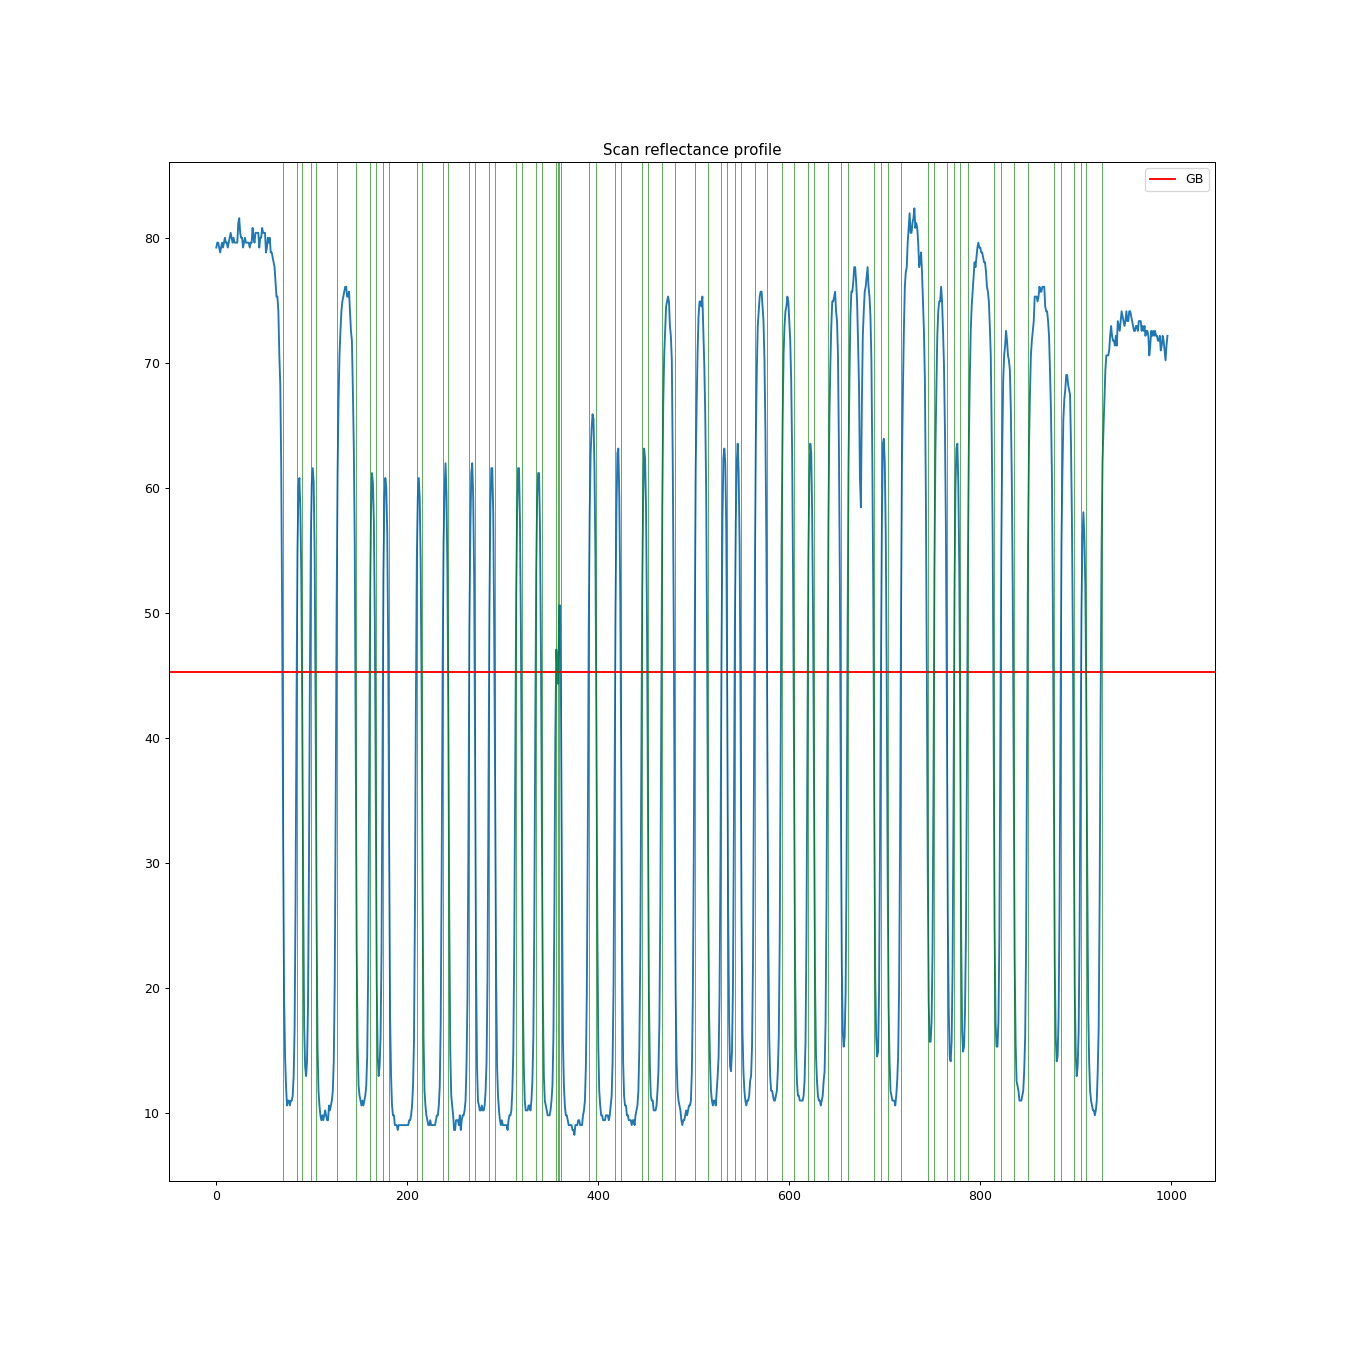

In [30]:
%matplotlib notebook
plt.figure(figsize=(15,15))
plt.plot(scanline)
plt.axhline(GB, c='r', label='GB')
for i in edges_indices:
    plt.axvline(i, c='g', lw=0.5)
plt.title('Scan reflectance profile')
plt.legend()

## Finding the peaks and the valleys
A peak is a local maximum, a valley is a local minimum. We recquire to compute peaks and valleys of our scanline in order to compute DEFECT.

In [31]:
# Scanline indices of the peaks pixels
peaks_indices = scipy.signal.find_peaks(scanline)
peaks_indices = peaks_indices[0]
peaks_indices

array([  1,   6,   9,  15,  18,  24,  30,  38,  42,  48,  54,  56,  75,
        87, 101, 111, 114, 118, 135, 139, 153, 163, 177, 212, 224, 240,
       252, 255, 268, 278, 288, 299, 316, 327, 337, 356, 359, 379, 394,
       409, 421, 436, 448, 473, 492, 506, 509, 521, 532, 546, 570, 598,
       622, 648, 668, 682, 699, 726, 731, 733, 738, 759, 776, 794, 798,
       827, 858, 862, 866, 890, 908, 937, 942, 944, 948, 953, 956, 963,
       967, 970, 972, 974, 979, 981, 983, 988, 991], dtype=int64)

<IPython.core.display.Javascript object>


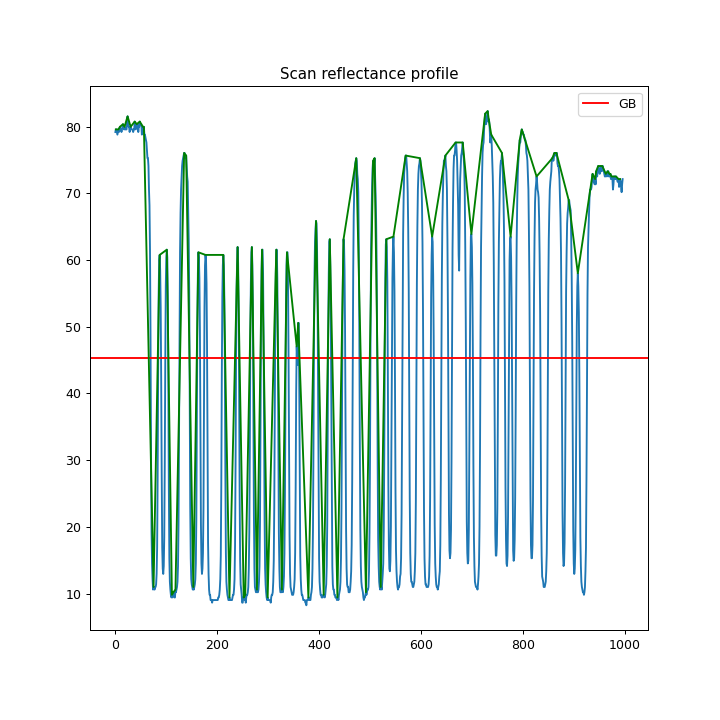

In [32]:
%matplotlib notebook
plt.figure(figsize=(8,8))
plt.plot(scanline)
plt.axhline(GB, c='r', label='GB')
plt.plot(peaks_indices, scanline[peaks_indices], c='g')
plt.title('Scan reflectance profile')
plt.legend()

In [33]:
# Scanline indices of the valleys pixels
valleys_indices = scipy.signal.find_peaks(100-scanline)
valleys_indices = valleys_indices[0]
valleys_indices

array([  4,   7,  12,  17,  20,  28,  35,  40,  45,  52,  55,  74,  77,
        94, 110, 112, 116, 119, 137, 152, 154, 170, 190, 222, 227, 249,
       254, 256, 276, 279, 298, 305, 325, 329, 348, 358, 375, 382, 406,
       411, 435, 438, 459, 488, 493, 508, 520, 523, 539, 555, 584, 612,
       633, 657, 675, 692, 711, 727, 732, 736, 747, 769, 782, 795, 817,
       842, 860, 863, 880, 901, 920, 941, 943, 946, 951, 954, 961, 965,
       969, 971, 973, 977, 980, 982, 986, 989, 994], dtype=int64)

<IPython.core.display.Javascript object>


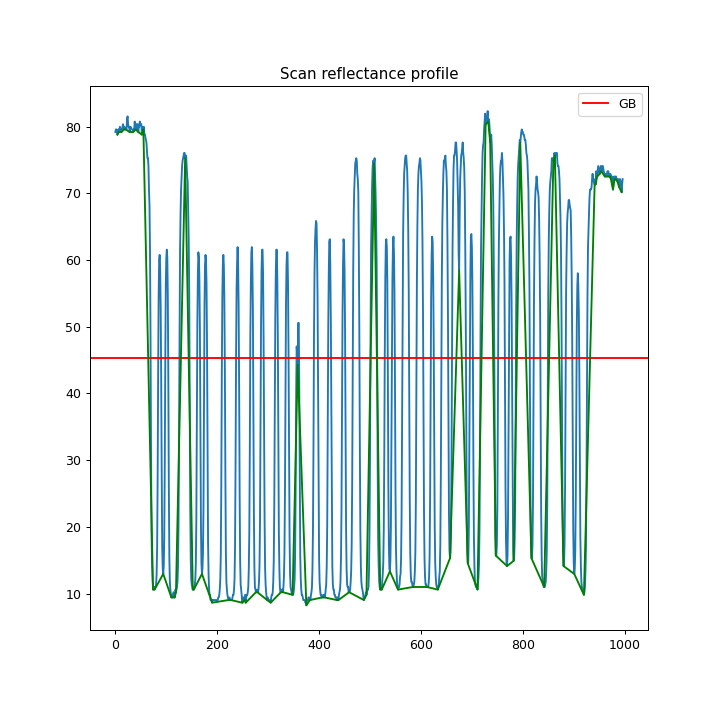

In [34]:
%matplotlib notebook
plt.figure(figsize=(8,8))
plt.plot(scanline)
plt.axhline(GB, c='r', label='GB')
plt.plot(valleys_indices, scanline[valleys_indices], c='g')
plt.title('Scan reflectance profile')
plt.legend()

### Defects

In [35]:
n_elements

71

In [36]:
scanline.shape

(997,)

In [38]:
ERN_list = []
peaksValleys_elements_list = []

for i in range(n_elements):
    if i==0:  # First element
        element_first_index = 0
        element_last_index = edges_indices[0]-1
    elif i<n_elements-1:  # Intermediate element
        element_first_index = edges_indices[i-1]
        element_last_index = edges_indices[i]-1
    else:  # Last element
        element_first_index = edges_indices[n_elements-2]
        element_last_index = scanline.shape[0]-1
    peaks_indices_within_element = peaks_indices[np.logical_and(peaks_indices>=element_first_index,peaks_indices<=element_last_index)]
    valleys_indices_within_element = valleys_indices[np.logical_and(valleys_indices>=element_first_index,valleys_indices<=element_last_index)]
    if peaks_indices_within_element.size==0 or valleys_indices_within_element.size==0:
        ERN_list.append(0)
        peaksValleys_elements_list.append((None,None))
        continue
    peaks_within_element = scanline[peaks_indices_within_element]#roi_image[scanline_index, peaks_indices_within_element]#scanline[peaks_indices_within_element]
    #print(valleys_within_element)
    valleys_within_element = scanline[valleys_indices_within_element]#roi_image[scanline_index, valleys_indices_within_element]#
    print(peaks_within_element.max(),valleys_within_element.min())
    ERN_list.append(peaks_within_element.max()-valleys_within_element.min())
    #print(np.argmin(valleys_within_element))
    #print(valleys_indices_within_element.shape)
    peaksValleys_elements_list.append((peaks_indices_within_element[np.argmax(peaks_within_element)],valleys_indices_within_element[np.argmin(valleys_within_element)]))    

81.56862745098039 78.82352941176471
10.980392156862745 10.588235294117647
10.588235294117647 9.411764705882353
76.07843137254902 75.29411764705883
10.980392156862745 10.588235294117647
9.411764705882353 9.019607843137255
9.803921568627452 8.627450980392156
10.588235294117647 10.196078431372548
9.411764705882353 8.627450980392156
10.588235294117647 10.196078431372548
9.411764705882353 8.235294117647058
9.803921568627452 9.411764705882353
9.411764705882353 9.019607843137255
10.196078431372548 9.019607843137255
75.29411764705883 74.50980392156863
10.980392156862745 10.588235294117647
77.64705882352942 58.43137254901961
82.35294117647058 77.64705882352942
79.6078431372549 77.64705882352942
76.07843137254902 74.90196078431373
74.11764705882354 70.19607843137254


In [39]:
ERN_max = max(ERN_list)
print('ERN_max:',ERN_max)
print()

ERN_max: 19.215686274509807



In [40]:
DEFECTS = ERN_max / SC


print('DEFECTS:',DEFECTS) 

DEFECTS: 0.2592592592592593


<IPython.core.display.Javascript object>


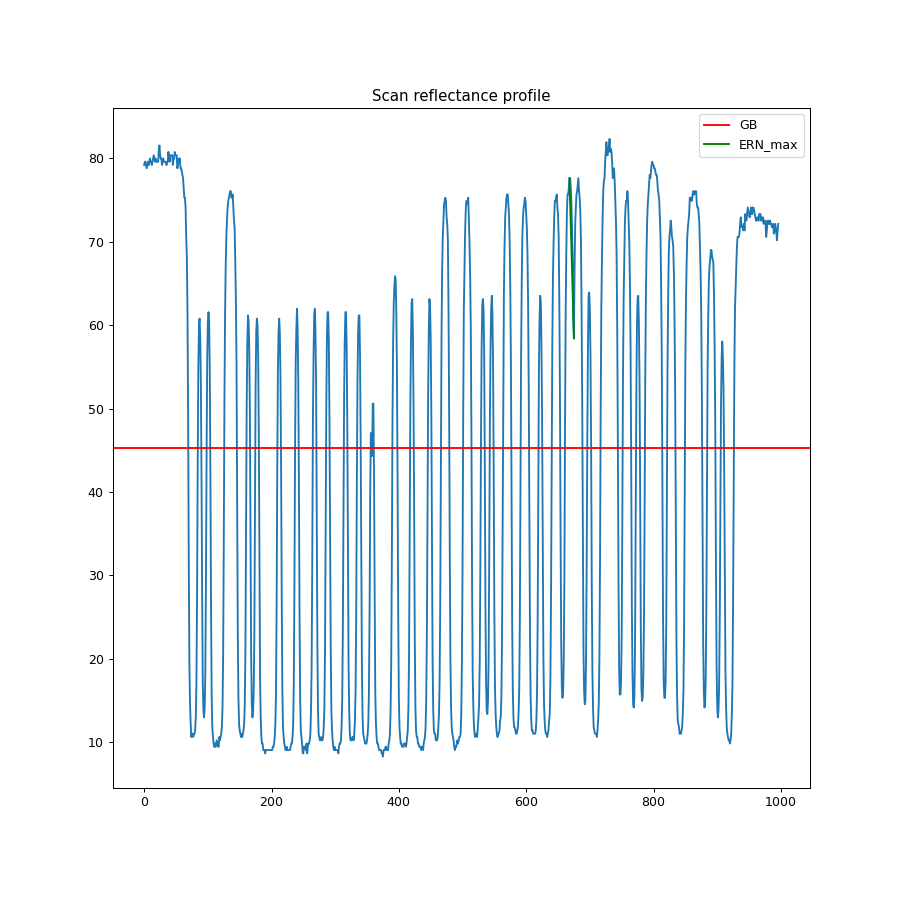

In [42]:
# Visualize ERN_max
peak_index, valley_index = peaksValleys_elements_list[np.argmax(ERN_list)]
peak_value, valley_value = scanline[peak_index], scanline[valley_index]

%matplotlib notebook
plt.figure(figsize=(10,10))
plt.plot(scanline)
plt.axhline(GB, c='r', label='GB')
plt.plot([peak_index, valley_index], [peak_value, valley_value], c='g', label='ERN_max')
plt.title('Scan reflectance profile')
plt.legend()

## Testing defects in different scanlines

In [51]:
def compute_defect(scanline):
    R_min = scanline.min()
    R_max = scanline.max()
    SC = R_max - R_min
    GB = R_min + SC/2

    mask = (scanline<GB).astype(int)
    mask_1 = np.append([0],mask[:-1])
    edges_mask = np.abs(mask - mask_1).astype(bool)
    edges_indices = np.indices(mask.shape)[0][edges_mask]
    n_elements = len(edges_indices)+1

    peaks_indices = scipy.signal.find_peaks(scanline)[0]
    valleys_indices = scipy.signal.find_peaks(100-scanline)[0]

    R_min = scanline.min()
    R_max = scanline.max()
    SC = R_max - R_min
    GB = R_min + SC/2

    mask = (scanline<GB).astype(int)
    mask_1 = np.append([0],mask[:-1])
    edges_mask = np.abs(mask - mask_1).astype(bool)
    edges_indices = np.indices(mask.shape)[0][edges_mask]
    n_elements = len(edges_indices)+1

    peaks_indices = scipy.signal.find_peaks(scanline)[0]
    valleys_indices = scipy.signal.find_peaks(100-scanline)[0]

    ERN_list = []
    peaksValleys_elements_list = []
    for i in range(n_elements):
        if i==0:
            element_first_index = 0
            element_last_index = edges_indices[0]-1
        elif i<n_elements-1:
            element_first_index = edges_indices[i-1]
            element_last_index = edges_indices[i]-1
        else:
            element_first_index = edges_indices[n_elements-2]
            element_last_index = scanline.shape[0]-1
        peaks_indices_within_element = peaks_indices[np.logical_and(peaks_indices>=element_first_index,peaks_indices<=element_last_index)]
        valleys_indices_within_element = valleys_indices[np.logical_and(valleys_indices>=element_first_index,valleys_indices<=element_last_index)]
        if peaks_indices_within_element.size==0 or valleys_indices_within_element.size==0:
            ERN_list.append(0)
            peaksValleys_elements_list.append((None,None))
            continue
        peaks_within_element = scanline[peaks_indices_within_element]
        valleys_within_element = scanline[valleys_indices_within_element]
        ERN_list.append(peaks_within_element.max()-valleys_within_element.min())
        peaksValleys_elements_list.append((peaks_indices_within_element[np.argmax(peaks_within_element)],valleys_indices_within_element[np.argmin(valleys_within_element)]))
    
    ERN_max = max(ERN_list)
    DEFECTS = ERN_max / SC
    
    peak_index, valley_index = peaksValleys_elements_list[np.argmax(ERN_list)]
    
    return DEFECTS, peak_index, valley_index

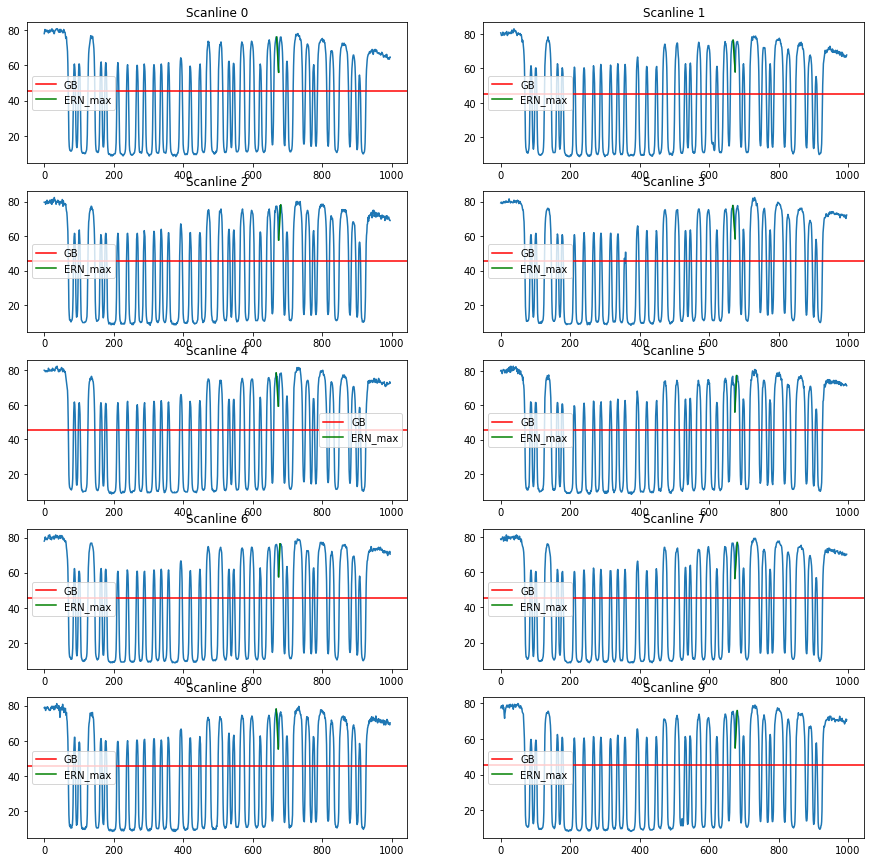

In [52]:
%matplotlib inline

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15,15), squeeze=True)

DEFECTS_list = []
for i, scanline_index in enumerate(scanlines_indices):
    scanline = roi_image_norm[scanline_index, :]
    
    DEFECTS, peak_index, valley_index = compute_defect(scanline)
    DEFECTS_list.append(DEFECTS)
    
    peak_value, valley_value = scanline[peak_index], scanline[valley_index]

    axs[i//2,i%2].plot(scanline)
    axs[i//2,i%2].axhline(GB, c='r', label='GB')
    axs[i//2,i%2].plot([peak_index, valley_index], [peak_value, valley_value], c='g', label='ERN_max')
    axs[i//2,i%2].set_title(f'Scanline {i}')
    axs[i//2,i%2].legend()

In [53]:
print('DEFECTS_list:', DEFECTS_list)
DEFECTS = np.mean(DEFECTS_list)
print('DEFECTS:', DEFECTS)

if DEFECTS<=0.15:
    DEFECTS_grade = 'A'
elif DEFECTS<=0.20:
    DEFECTS_grade = 'B'
elif DEFECTS<=0.25:
    DEFECTS_grade = 'C'
elif DEFECTS<=0.30:
    DEFECTS_grade = 'D'
else:
    DEFECTS_grade = 'E'
print('DEFECTS_grade:', DEFECTS_grade)

DEFECTS_list: [0.2756756756756757, 0.24736842105263143, 0.27513227513227534, 0.2592592592592593, 0.2592592592592593, 0.28421052631578964, 0.2580645161290323, 0.28108108108108126, 0.31182795698924737, 0.2912087912087912]
DEFECTS: 0.27430877621030425
DEFECTS_grade: D


## INSIGHT: WHAT HAPPENS IF WE DON'T CONSIDER SIMPLY THE PEAKS

In [103]:
ERN_list = []
element = scanline[:edges_first_indices[0]]
ERN_list.append(element.max()-element.min())
for i, edge_first_index in enumerate(edges_first_indices): 
    if i>=len(edges_first_indices)-1:
        element = scanline[edge_first_index:]
    else:
        element = scanline[edge_first_index:edges_first_indices[i+1]]
    ERN_list.append(element.max()-element.min())
    
ERN_max = max(ERN_list)

DEFECTS = ERN_max / SC

DEFECTS

0.4868421052631579

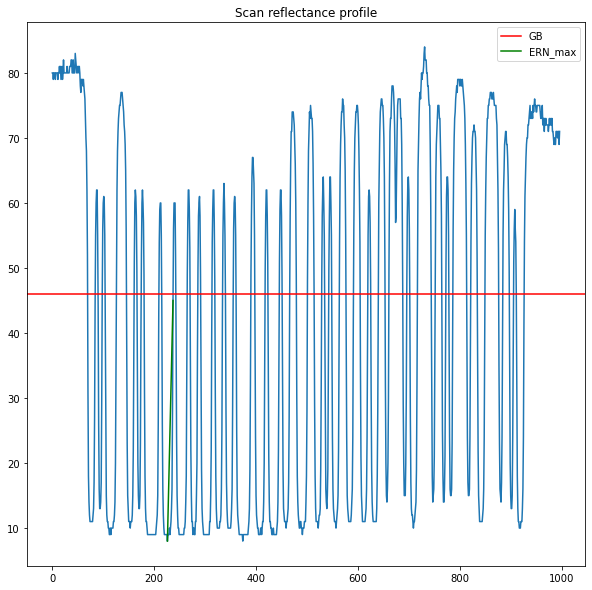

In [104]:
# Visualize ERN_max
ERN_max_edge_index = np.argmax(ERN_list)
if ERN_max_edge_index==0:
    element = scanline[:edges_first_indices[0]]
    element_first_index = 0
elif ERN_max_edge_index<len(ERN_list)-1:
    element = scanline[edges_first_indices[ERN_max_edge_index-1]:edges_first_indices[ERN_max_edge_index]]
    element_first_index = edges_first_indices[ERN_max_edge_index-1]
else:
    element = scanline[edges_first_indices[ERN_max_edge_index-1]:]
    element_first_index = edges_first_indices[ERN_max_edge_index-1]
    
max_index = np.argmax(element) + element_first_index
max_value = np.max(element)
min_index = np.argmin(element) + element_first_index
min_value = np.min(element)

%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot(scanline)
plt.axhline(GB, c='r', label='GB')
plt.plot([min_index, max_index], [min_value, max_value], c='g', label='ERN_max')
plt.title('Scan reflectance profile')
plt.legend()

In [105]:
scanline[max_index]

45.0

In [106]:
GB

46.0

In [108]:
roi_image[scanline_index, max_index]

116

## OTHER IMAGES (BLACKBOARD FOR TESTING)

../images/EAN128-CONTRAST IMGB.BMP


<IPython.core.display.Javascript object>


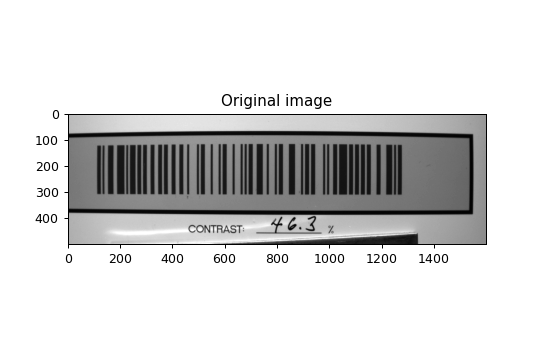

<IPython.core.display.Javascript object>


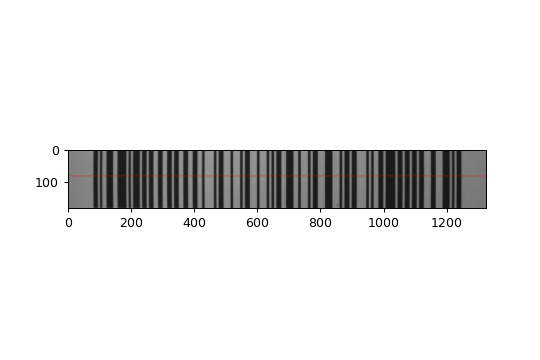

<IPython.core.display.Javascript object>


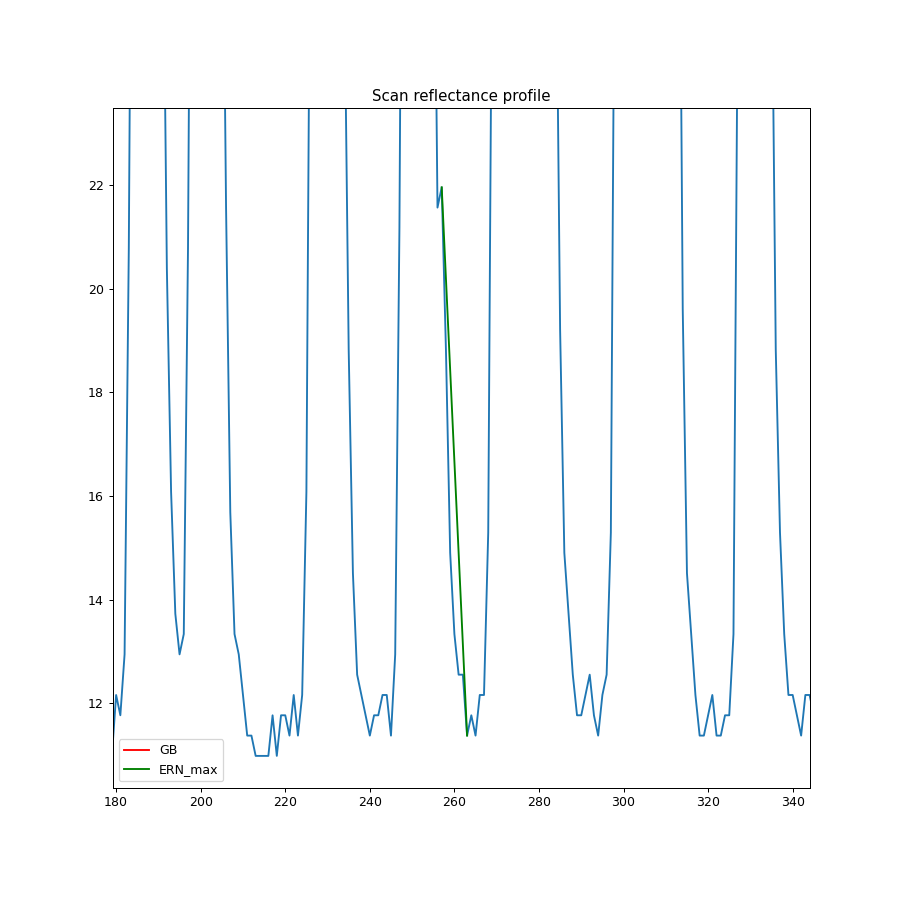

In [57]:
%matplotlib notebook
image_path = f'../images/{images_paths[13]}'
print(image_path)
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)   

plt.figure()
plt.imshow(gray, 'gray')
plt.title('Original image')  

roi_image, bb_points_sorted_rot, bb_width, bb_height = detect_and_refine_boundingBox(image, 
                            use_same_threshold=False, compute_barcode_structure_algorithm=1, verbose_timing=False,
                            outlier_detection_level=0.02, visualization_dict=None)

scanlines_indices = np.linspace(start=0, stop=bb_height, num=12, dtype=int)[1:-1]
roi_image_norm = 100*(roi_image/255)

scanline_index = scanlines_indices[4]#math.ceil(bb_height/2)
scanline = roi_image_norm[scanline_index, :]

roi_image_tmp = roi_image.copy()
roi_image_tmp = cv2.cvtColor(roi_image_tmp, cv2.COLOR_GRAY2RGB)
roi_image_tmp[scanline_index,:,:] = np.array([255,0,0])
plt.figure()
plt.imshow(roi_image_tmp, 'gray') 

R_min = scanline.min()
R_max = scanline.max()
SC = R_max - R_min
GB = R_min + SC/2

mask = (scanline<GB).astype(int)  # Mask saying which scanline pixel belongs to a bar
mask_1 = np.append([0],mask[:-1])  # Same mask of before, but traslated of one position to the right
edges_mask = np.abs(mask - mask_1).astype(bool)
edges_indices = np.indices(mask.shape)[0][edges_mask]
n_elements = len(edges_indices)+1

peaks_indices = scipy.signal.find_peaks(scanline)
peaks_indices = peaks_indices[0]
valleys_indices = scipy.signal.find_peaks(100-scanline)
valleys_indices = valleys_indices[0]

ERN_list = []
peaksValleys_elements_list = []

for i in range(n_elements):
    if i==0:  # First element
        element_first_index = 0
        element_last_index = edges_indices[0]-1
    elif i<n_elements-1:  # Intermediate element
        element_first_index = edges_indices[i-1]
        element_last_index = edges_indices[i]-1
    else:  # Last element
        element_first_index = edges_indices[n_elements-2]
        element_last_index = scanline.shape[0]-1
    peaks_indices_within_element = peaks_indices[np.logical_and(peaks_indices>=element_first_index,peaks_indices<=element_last_index)]
    valleys_indices_within_element = valleys_indices[np.logical_and(valleys_indices>=element_first_index,valleys_indices<=element_last_index)]
    if peaks_indices_within_element.size==0 or valleys_indices_within_element.size==0:
        ERN_list.append(0)
        peaksValleys_elements_list.append((None,None))
        continue
    peaks_within_element = scanline[peaks_indices_within_element]#roi_image[scanline_index, peaks_indices_within_element]#scanline[peaks_indices_within_element]
    #print(valleys_within_element)
    valleys_within_element = scanline[valleys_indices_within_element]#roi_image[scanline_index, valleys_indices_within_element]#
    #print(peaks_within_element.max(),valleys_within_element.min())
    ERN_list.append(peaks_within_element.max()-valleys_within_element.min())
    #print(np.argmin(valleys_within_element))
    #print(valleys_indices_within_element.shape)
    peaksValleys_elements_list.append((peaks_indices_within_element[np.argmax(peaks_within_element)],valleys_indices_within_element[np.argmin(valleys_within_element)]))   
    
ERN_max = max(ERN_list)
DEFECTS = ERN_max / SC

peak_index, valley_index = peaksValleys_elements_list[np.argmax(ERN_list)]
peak_value, valley_value = scanline[peak_index], scanline[valley_index]

plt.figure(figsize=(10,10))
plt.plot(scanline)
plt.axhline(GB, c='r', label='GB')
plt.plot([peak_index, valley_index], [peak_value, valley_value], c='g', label='ERN_max')
plt.title('Scan reflectance profile')
plt.legend()